In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import shutil
import warnings
import matplotlib.patches as mpatches
from IPython.display import Image
import pygeostat as gs

%load_ext autoreload
%autoreload 2

%pylab inline --no-import-all
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Summary Statistics for Well Data

The main statistics for sampled well data are checked with proper visualizations

## vtk visulization for a petroleum reservoir model and sampled wells

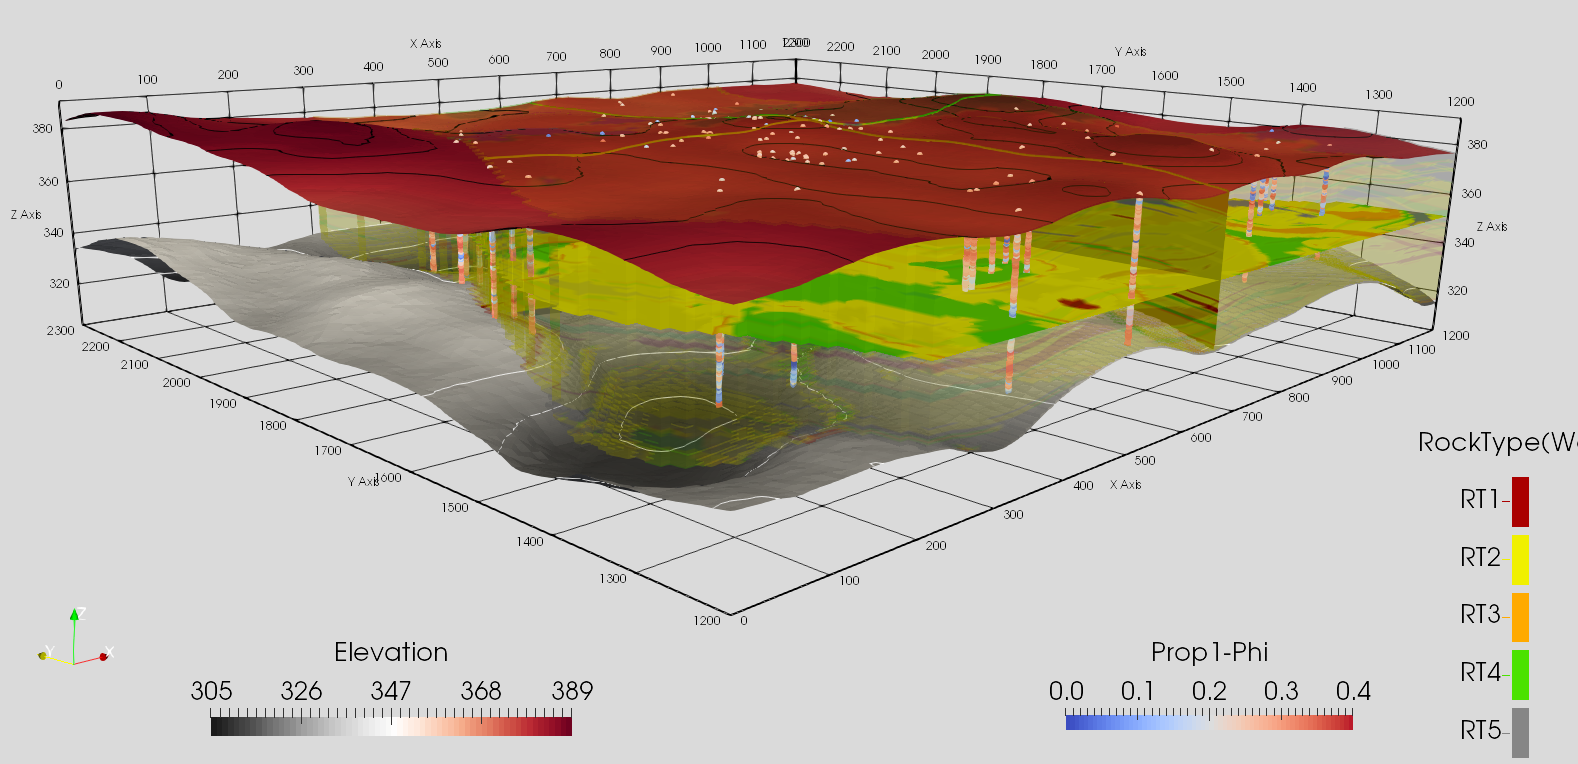

In [2]:
Image(filename='data/F1.png')

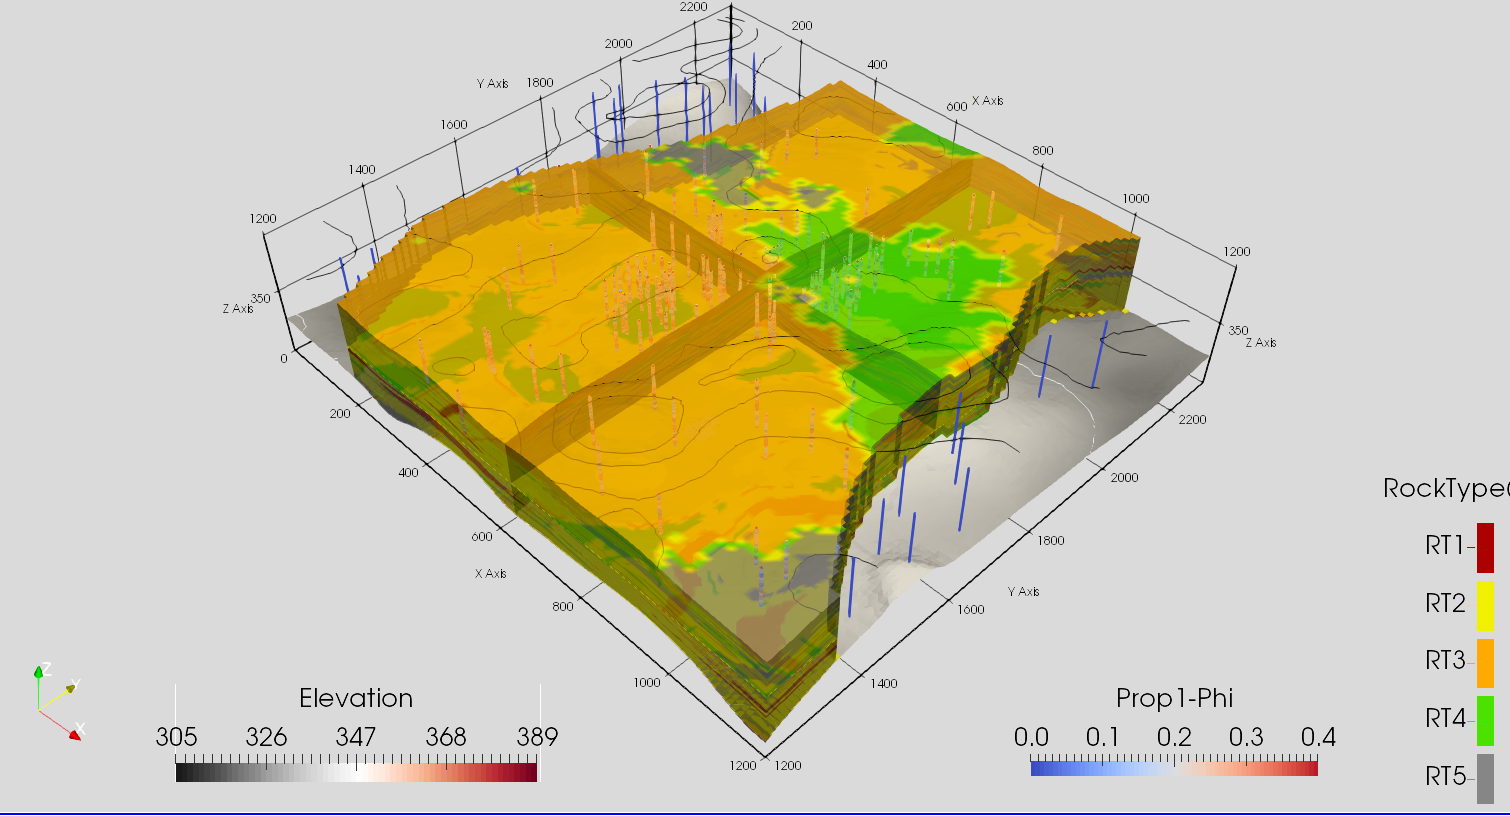

In [3]:
Image(filename='data/F2.png')

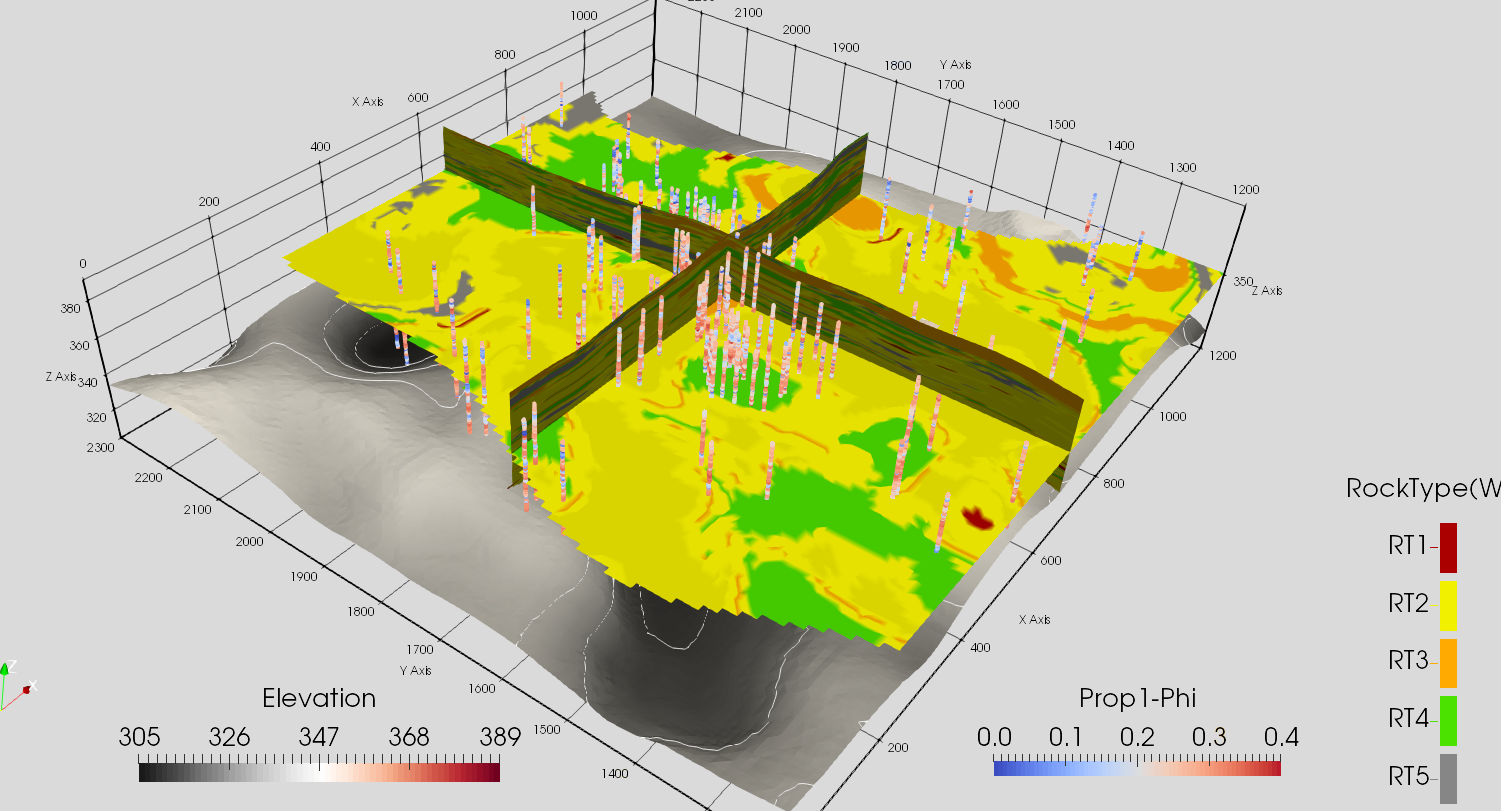

In [4]:
Image(filename='data/F3.png')

## Boundary modelling Data

Checking data with keyout (inside/outside) reservoir data. This data will be used for boundary modeling.

In [7]:
Boundary_DF = gs.DataFile('data/Baoundary_Final.dat')
Boundary_DF.data.head()

,HoleID,X,Y,Keyout
0,1.0,85.0,2215.0,0.0
1,2.0,1105.0,2085.0,0.0
2,3.0,405.0,1715.0,1.0
3,4.0,195.0,2055.0,0.0
4,5.0,235.0,1865.0,1.0


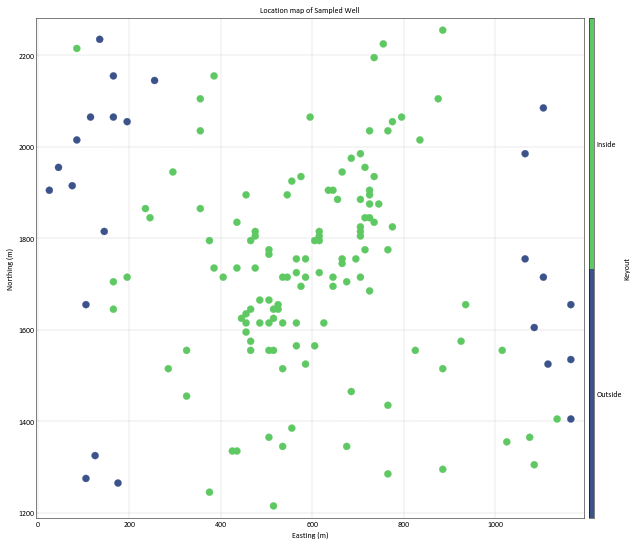

In [8]:
gs.locmap(Boundary_DF, x='X', y='Y',var='Keyout', figsize=(10,10), cbar_label='Keyout', grid=True,
          s=50, catdata=True, catdict={'Outside': 0, 'Inside': 1}, title='Location map of Sampled Well')

## Rock type and Petrophysical Properties

In [11]:
Well_DF = gs.DataFile('data/SampledWell_Final.dat')
Well_DF.data.head()

,HoleID,X,Y,Elevation,Z_Top,Z_Bottom,RockType,Prop1-Phi,Prop2-Vsh,Prop3-Kv,Prop4-Kh,Prop5-Sw
0,3.0,405.0,1715.0,330.54334,382.79334,330.18146,5.0,0.138597,0.421818,0.00010,0.00100,0.783311
1,3.0,405.0,1715.0,331.04334,382.79334,330.18146,5.0,0.078082,0.666037,0.00010,0.00100,0.922857
2,3.0,405.0,1715.0,331.54334,382.79334,330.18146,3.0,0.317862,0.215853,727.41432,1819.14960,0.131871
3,3.0,405.0,1715.0,332.04334,382.79334,330.18146,3.0,0.397035,0.035916,8158.62840,9486.77730,0.118336
4,3.0,405.0,1715.0,332.54334,382.79334,330.18146,1.0,0.241755,0.235848,204.91616,697.51595,0.475459


### Get the global proportions for rock types

In [12]:
RT_code = np.unique(Well_DF.data['RockType'])
RT_name = ['RT%i'%(i) for i in RT_code]
RD_dict = dict(zip(RT_code, RT_name))
RD_dict

{1.0: 'RT1', 2.0: 'RT2', 3.0: 'RT3', 4.0: 'RT4', 5.0: 'RT5'}

In [13]:
Well_DF.data['RockTypeName'] = Well_DF.data['RockType'].apply(lambda x: RD_dict[x])
Well_DF.data.head()

,HoleID,X,Y,Elevation,Z_Top,Z_Bottom,RockType,Prop1-Phi,Prop2-Vsh,Prop3-Kv,Prop4-Kh,Prop5-Sw,RockTypeName
0,3.0,405.0,1715.0,330.54334,382.79334,330.18146,5.0,0.138597,0.421818,0.00010,0.00100,0.783311,RT5
1,3.0,405.0,1715.0,331.04334,382.79334,330.18146,5.0,0.078082,0.666037,0.00010,0.00100,0.922857,RT5
2,3.0,405.0,1715.0,331.54334,382.79334,330.18146,3.0,0.317862,0.215853,727.41432,1819.14960,0.131871,RT3
3,3.0,405.0,1715.0,332.04334,382.79334,330.18146,3.0,0.397035,0.035916,8158.62840,9486.77730,0.118336,RT3
4,3.0,405.0,1715.0,332.54334,382.79334,330.18146,1.0,0.241755,0.235848,204.91616,697.51595,0.475459,RT1


In [14]:
Proportion = Well_DF.data.groupby(['RockTypeName'],as_index=False).count()
Proportion = Proportion[['RockTypeName', 'RockType']]
Proportion.columns=['RockTypeName', 'Proportion']
Proportion['Proportion'] = Proportion['Proportion'].apply(lambda x: x/len(Well_DF.data))
Proportion

,RockTypeName,Proportion
0,RT1,0.042461
1,RT2,0.392264
2,RT3,0.233073
3,RT4,0.220875
4,RT5,0.111326


### Uni/Bi variate relationships for different properties within each rock type

In [15]:
variables = ['Prop1-Phi', 'Prop2-Vsh', 'Prop3-Kv', 'Prop4-Kh', 'Prop5-Sw']
utrivars = [(vx, vy) for j, vx in enumerate(variables) for i, vy in enumerate(variables) if i > j ]

#### RockType 1

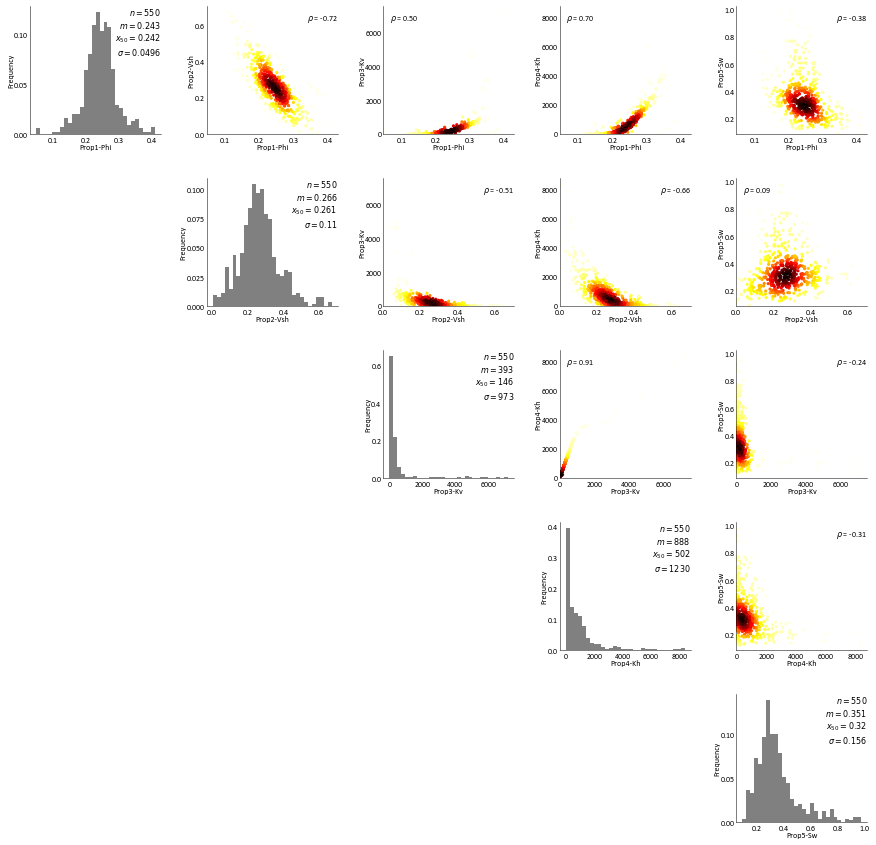

In [16]:
dat = Well_DF.data[Well_DF.data['RockType']==1]
# setup some custom styles for the output
pltstyle = 'ccgpaper'
cust_style = None

# Upper Triangle: KDE plot
def iter_upper(axes):
    for ax, (varx, vary) in zip(axes, utrivars):
        gs.kdeplot(dat[varx], dat[vary], ax=ax, density=False, rotateticks=(False, False), cmap="hot_r", 
                   cbar=False, contour=True, lw=0.5, pltstyle=pltstyle, cust_style=cust_style, s=10,
                   threshold=0.1, shade=False) 
        # tighten the label spacing
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Diagonal: Histograms
def iter_diagonal(axes):
    for ax, var in zip(axes, variables):
        gs.histplt(dat[var], ax=ax, color="grey", pltstyle=pltstyle, cust_style=cust_style, 
                   xlabel=var)
        # tighten the label spacing        
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Setup the imagegrid using symmetric, the three functions, and the `unequal_aspects` keyword
# which allows the histograms to be plotted along side the bivariate plots without strange aspect
# issues
fig = gs.imagegrid(upperfunc=iter_upper, diagfunc=iter_diagonal, nvar=len(variables), 
                   symmetric=True, unequal_aspects=True, axes_pad=(0.35, 0.35), 
                   ntickbins=(6,5), pltstyle=pltstyle, cust_style=cust_style, figsize=(15, 15))

#### RockType 2

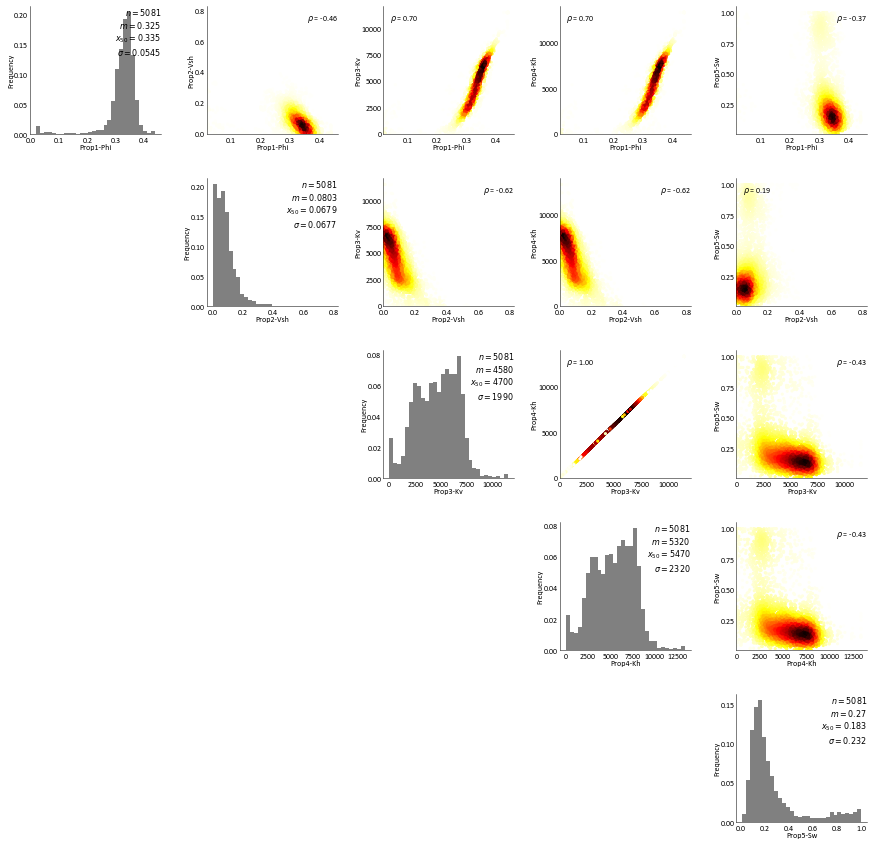

In [17]:
dat = Well_DF.data[Well_DF.data['RockType']==2]
# setup some custom styles for the output
pltstyle = 'ccgpaper'
cust_style = None

# Upper Triangle: KDE plot
def iter_upper(axes):
    for ax, (varx, vary) in zip(axes, utrivars):
        gs.kdeplot(dat[varx], dat[vary], ax=ax, density=False, rotateticks=(False, False), cmap="hot_r", 
                   cbar=False, contour=True, lw=0.5, pltstyle=pltstyle, cust_style=cust_style, s=10,
                   threshold=0.1, shade=False) 
        # tighten the label spacing
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Diagonal: Histograms
def iter_diagonal(axes):
    for ax, var in zip(axes, variables):
        gs.histplt(dat[var], ax=ax, color="grey", pltstyle=pltstyle, cust_style=cust_style, 
                   xlabel=var)
        # tighten the label spacing        
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Setup the imagegrid using symmetric, the three functions, and the `unequal_aspects` keyword
# which allows the histograms to be plotted along side the bivariate plots without strange aspect
# issues
fig = gs.imagegrid(upperfunc=iter_upper, diagfunc=iter_diagonal, nvar=len(variables), 
                   symmetric=True, unequal_aspects=True, axes_pad=(0.35, 0.35), 
                   ntickbins=(6,5), pltstyle=pltstyle, cust_style=cust_style, figsize=(15, 15))

#### RockType 3

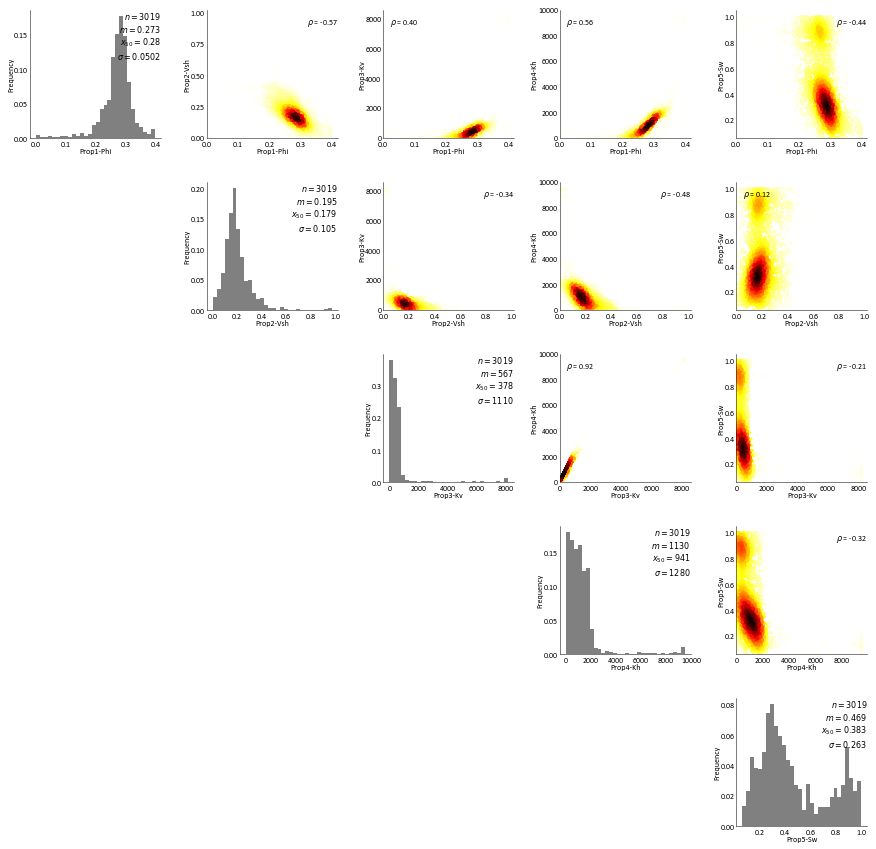

In [18]:
dat = Well_DF.data[Well_DF.data['RockType']==3]
# setup some custom styles for the output
pltstyle = 'ccgpaper'
cust_style = None

# Upper Triangle: KDE plot
def iter_upper(axes):
    for ax, (varx, vary) in zip(axes, utrivars):
        gs.kdeplot(dat[varx], dat[vary], ax=ax, density=False, rotateticks=(False, False), cmap="hot_r", 
                   cbar=False, contour=True, lw=0.5, pltstyle=pltstyle, cust_style=cust_style, s=10,
                   threshold=0.1, shade=False) 
        # tighten the label spacing
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Diagonal: Histograms
def iter_diagonal(axes):
    for ax, var in zip(axes, variables):
        gs.histplt(dat[var], ax=ax, color="grey", pltstyle=pltstyle, cust_style=cust_style, 
                   xlabel=var)
        # tighten the label spacing        
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Setup the imagegrid using symmetric, the three functions, and the `unequal_aspects` keyword
# which allows the histograms to be plotted along side the bivariate plots without strange aspect
# issues
fig = gs.imagegrid(upperfunc=iter_upper, diagfunc=iter_diagonal, nvar=len(variables), 
                   symmetric=True, unequal_aspects=True, axes_pad=(0.35, 0.35), 
                   ntickbins=(6,5), pltstyle=pltstyle, cust_style=cust_style, figsize=(15, 15))

#### RockType 4

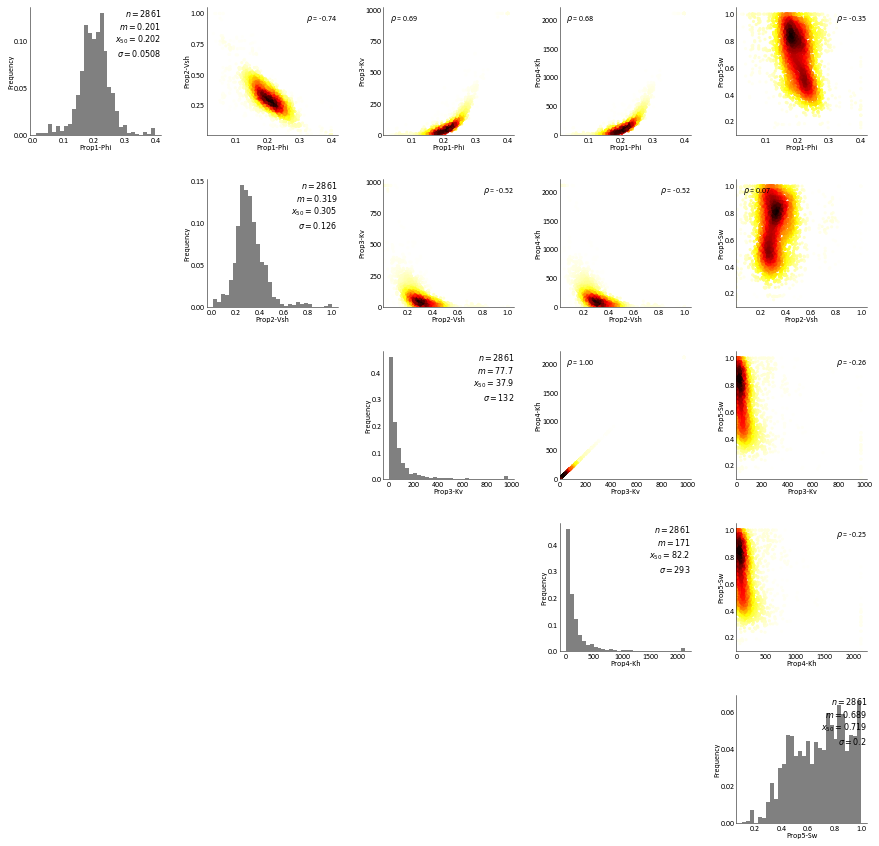

In [19]:
dat = Well_DF.data[Well_DF.data['RockType']==4]
# setup some custom styles for the output
pltstyle = 'ccgpaper'
cust_style = None

# Upper Triangle: KDE plot
def iter_upper(axes):
    for ax, (varx, vary) in zip(axes, utrivars):
        gs.kdeplot(dat[varx], dat[vary], ax=ax, density=False, rotateticks=(False, False), cmap="hot_r", 
                   cbar=False, contour=True, lw=0.5, pltstyle=pltstyle, cust_style=cust_style, s=10,
                   threshold=0.1, shade=False) 
        # tighten the label spacing
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Diagonal: Histograms
def iter_diagonal(axes):
    for ax, var in zip(axes, variables):
        gs.histplt(dat[var], ax=ax, color="grey", pltstyle=pltstyle, cust_style=cust_style, 
                   xlabel=var)
        # tighten the label spacing        
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Setup the imagegrid using symmetric, the three functions, and the `unequal_aspects` keyword
# which allows the histograms to be plotted along side the bivariate plots without strange aspect
# issues
fig = gs.imagegrid(upperfunc=iter_upper, diagfunc=iter_diagonal, nvar=len(variables), 
                   symmetric=True, unequal_aspects=True, axes_pad=(0.35, 0.35), 
                   ntickbins=(6,5), pltstyle=pltstyle, cust_style=cust_style, figsize=(15, 15))

#### RockType 5

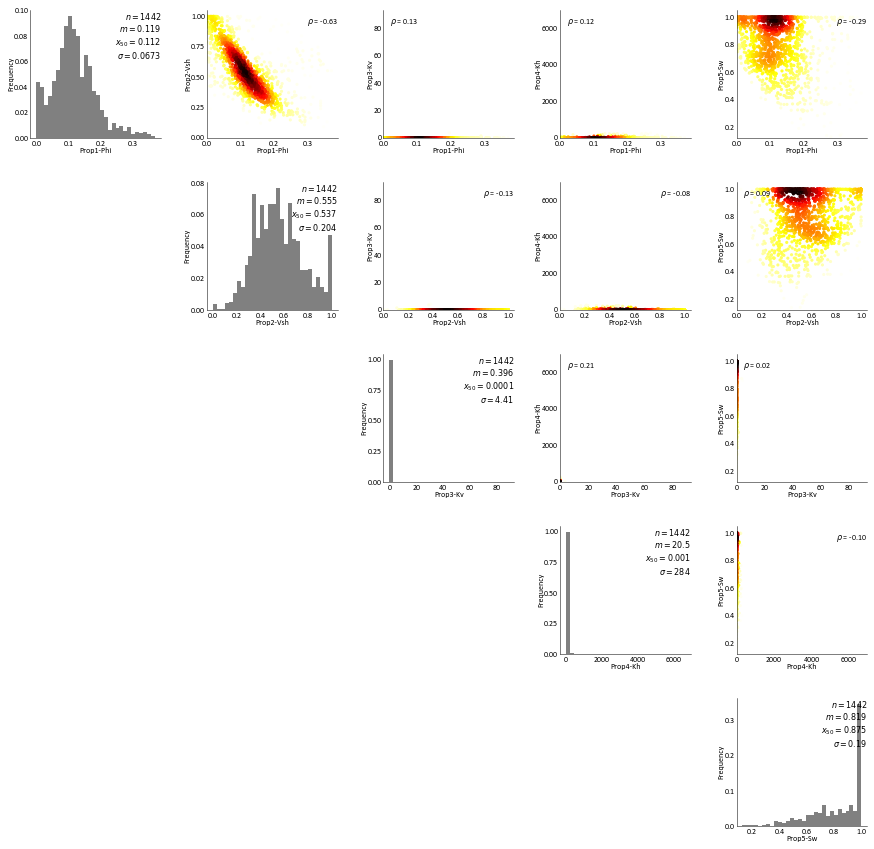

In [20]:
dat = Well_DF.data[Well_DF.data['RockType']==5]
# setup some custom styles for the output
pltstyle = 'ccgpaper'
cust_style = None

# Upper Triangle: KDE plot
def iter_upper(axes):
    for ax, (varx, vary) in zip(axes, utrivars):
        gs.kdeplot(dat[varx], dat[vary], ax=ax, density=False, rotateticks=(False, False), cmap="hot_r", 
                   cbar=False, contour=True, lw=0.5, pltstyle=pltstyle, cust_style=cust_style, s=10,
                   threshold=0.1, shade=False) 
        # tighten the label spacing
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Diagonal: Histograms
def iter_diagonal(axes):
    for ax, var in zip(axes, variables):
        gs.histplt(dat[var], ax=ax, color="grey", pltstyle=pltstyle, cust_style=cust_style, 
                   xlabel=var)
        # tighten the label spacing        
        ax.yaxis.labelpad = 0
        ax.xaxis.labelpad = 0
        ax.tick_params(axis='both', which='major', pad=0)
        yield ax
        
# Setup the imagegrid using symmetric, the three functions, and the `unequal_aspects` keyword
# which allows the histograms to be plotted along side the bivariate plots without strange aspect
# issues
fig = gs.imagegrid(upperfunc=iter_upper, diagfunc=iter_diagonal, nvar=len(variables), 
                   symmetric=True, unequal_aspects=True, axes_pad=(0.35, 0.35), 
                   ntickbins=(6,5), pltstyle=pltstyle, cust_style=cust_style, figsize=(15, 15))